In [1]:
%matplotlib inline
import math
import numpy as np
import numpy.random as nrand
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import scipy.stats as stats
from pandas_datareader import data
from stockmarket.stylizedfacts import *
from math import isclose
import matplotlib.cm as cm
from pandas.tools.plotting import autocorrelation_plot
from stockmarket.database import create_CDA_tables, record_state_variables

In [2]:
import powerlaw
from tqdm import *

In [3]:
start_date = '2010-01-01'
end_date = '2016-12-31'

spy = data.DataReader("SPY", 
                       start=start_date, 
                       end=end_date, 
                       data_source='google')['Close']

#spy.plot(title='AAPL Adj. Closing Price')
spy_returns = spy.pct_change()

In [4]:
spy_volume = data.DataReader("SPY", 
                       start=start_date, 
                       end=end_date, 
                       data_source='google')['Volume']

# Simulation

In [4]:
from stockmarket import baselinemodel

In [5]:
#%prun baselinemodel.stockMarketSimulation(seed=0, simulation_time=10, amount_momentum=40, amount_mean_reversion=40, amount_firms=1,initial_money=(100, 200),initial_bid_ask=(1,1), initial_memory=(3,7),initial_ma_short=(2,3), initial_ma_long=(6,7),initial_profit=(200,200),initial_book_value=(10000, 10000),initial_stock_amount=400,order_expiration_time=120,init_propensity_to_switch=1.1,init_price_to_earnings_window=(6, 12),firm_profit_mu=0.058,firm_profit_delta=0.00396825396,firm_profit_sigma=0.125,printProgress=False)

In [6]:
SIMTIME = 200

In [7]:
calibratedParams = {"price_to_earnings_base": 11, 
                    "longMA_heterogeneity": 1.441986880130183, 
                    "price_to_earnings_gap": 11, 
                    "agents_hold_thresholds": 0.009787868843112115, 
                    "agent_ma_long": 65, 
                    "shortMA_heterogeneity": 1.204473734660668, 
                    "price_to_earnings_heterogeneity": 1.2809853358963714, 
                    "profit_announcement_working_days": 13, 
                    "agent_order_price_variability": 2, 
                    "agent_volume_risk_aversion": 0.15710589508611844, 
                    "share_chartists": 0.6360219452317543, 
                    "agent_order_variability": 0.41645196996101297, 
                    "agent_propensity_to_switch": 1.879037190114386, 
                    "agent_ma_short": 50, 
                    "shortMA_memory_divider": 3.539424126160756, 
                    "share_mean_reversion": 0.3380862907737759, 
                    "order_expiration_time": 6791}

In [8]:
initial_total_money = 26000
init_profit = 1000
init_discount_rate = 0.17
price_to_earnings_base = calibratedParams['price_to_earnings_base']
longMA_heterogeneity = calibratedParams['longMA_heterogeneity']
price_to_earnings_gap = calibratedParams['price_to_earnings_gap']
agents_hold_thresholds = calibratedParams['agents_hold_thresholds']
agent_ma_long = calibratedParams['agent_ma_long']
shortMA_heterogeneity = calibratedParams['shortMA_heterogeneity']
price_to_earnings_heterogeneity = calibratedParams['price_to_earnings_heterogeneity']
profit_announcement_working_days = calibratedParams['profit_announcement_working_days']
agent_order_price_variability = calibratedParams['agent_order_price_variability']
agent_volume_risk_aversion = calibratedParams['agent_volume_risk_aversion']
share_chartists = calibratedParams['share_chartists']
agent_order_variability = calibratedParams['agent_order_variability']
agent_propensity_to_switch = calibratedParams['agent_propensity_to_switch']
agent_ma_short = calibratedParams['agent_ma_short']
shortMA_memory_divider = calibratedParams['shortMA_memory_divider']
share_mean_reversion = calibratedParams['share_mean_reversion']
order_expiration_time = calibratedParams['order_expiration_time']

In [9]:
PE_low_low = price_to_earnings_base
PE_low_high = int(price_to_earnings_heterogeneity*price_to_earnings_base)
PE_high_low = PE_low_high + price_to_earnings_gap
PE_high_high = int(price_to_earnings_heterogeneity*PE_high_low)

In [10]:
NRUNS = 50

In [11]:
import sqlite3

In [12]:
conn = sqlite3.connect('baseline.sqlite')
cur = conn.cursor()

In [13]:
for seed in tqdm(range(NRUNS)):
    create_CDA_tables(cur, seed)
    agents, firms, stocks, order_books = baselinemodel.stockMarketSimulation(seed=0,
                                                                             simulation_time=SIMTIME,
                                                                         init_backward_simulated_time=int(agent_ma_long*longMA_heterogeneity),
                                                                         number_of_agents=1000,
                                                                         share_chartists=share_chartists,
                                                                         share_mean_reversion=share_mean_reversion,
                                                                         amount_of_firms=1,
                                                                         initial_total_money=(initial_total_money,int(initial_total_money*1.1)),
                                                                         initial_profit=(init_profit, init_profit),
                                                                         discount_rate=init_discount_rate,
                                                                         init_price_to_earnings_window=((PE_low_low,
                                                                                                         PE_low_high),
                                                                                                        (PE_high_low,
                                                                                                         PE_high_high)),
                                                                         order_expiration_time=order_expiration_time,
                                                                         agent_order_price_variability=(agent_order_price_variability,agent_order_price_variability),
                                                                         agent_order_variability=agent_order_variability,
                                                                         agent_ma_short=(agent_ma_short, int(agent_ma_short*shortMA_heterogeneity)),
                                                                         agent_ma_long=(agent_ma_long, int(agent_ma_long*longMA_heterogeneity)),
                                                                         agents_hold_thresholds=(1-agents_hold_thresholds, 1+agents_hold_thresholds),
                                                                         agent_volume_risk_aversion=agent_volume_risk_aversion,
                                                                         agent_propensity_to_switch=agent_propensity_to_switch,
                                                                         firm_profit_mu=0.058,
                                                                         firm_profit_delta=0.00396825396,
                                                                         firm_profit_sigma=0.125,
                                                                         profit_announcement_working_days=profit_announcement_working_days,
                                                                             mean_reversion_memory_divider=4,
                                                                         printProgress=False,
                                                                         )
    record_state_variables(cur, seed, agents, SIMTIME, firms, stocks, order_books)
    conn.commit()

100%|██████████████████████████████████████████| 50/50 [53:59<00:00, 76.54s/it]


In [14]:
cur.close()

# Quick results

## Firm profits

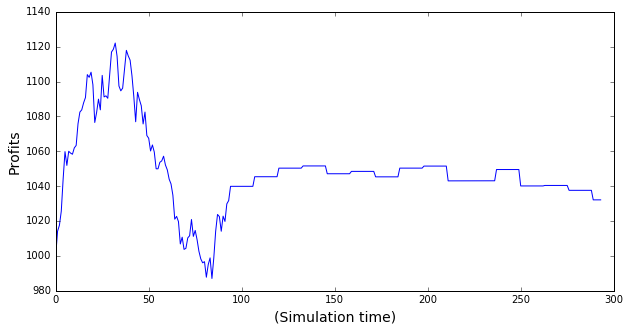

In [13]:
profits = firms[0].profit_history

fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(profits)), profits)

ax1.set_ylabel('Profits', fontsize='14')
ax1.set_xlabel('(Simulation time)', fontsize='14')

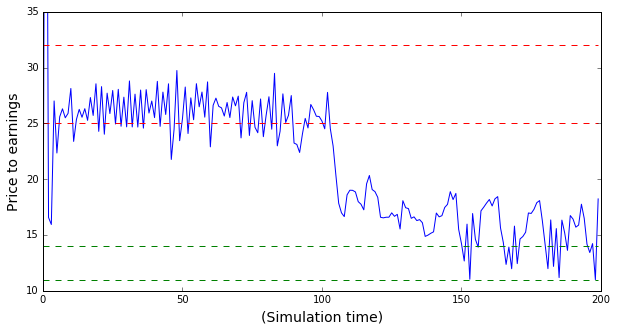

In [46]:
price_to_earnings = stocks[0].price_to_earnings_history

fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(price_to_earnings)), price_to_earnings)
ax1.plot(range(len(price_to_earnings)), [PE_low_low for x in range(len(price_to_earnings))], 'g--')
ax1.plot(range(len(price_to_earnings)), [PE_low_high for x in range(len(price_to_earnings))], 'g--')
ax1.plot(range(len(price_to_earnings)), [PE_high_low for x in range(len(price_to_earnings))], 'r--')
ax1.plot(range(len(price_to_earnings)), [PE_high_high for x in range(len(price_to_earnings))], 'r--')
#ax1.plot(range(len(price_to_earnings)), )

ax1.set_ylim(10, 35)

ax1.set_ylabel('Price to earnings', fontsize='14')
ax1.set_xlabel('(Simulation time)', fontsize='14')
fig.savefig('price_to_earning_calibrated_model.png')

In [15]:
def calculate_returns(orderbook_transaction_price_history):
    """Return the returns"""
    closing_prices = []
    for day in orderbook_transaction_price_history:
        closing_prices.append(day[-1])
    returns = pd.Series(closing_prices).pct_change()
    return returns[1:]

In [16]:
returns = calculate_returns(order_books[0].transaction_prices_history)
absolute_returns = returns.abs()
lags = 25
autocorr_abs_returns = [absolute_returns.autocorr(lag=lag) for lag in range(lags)]
average_autocorrelation = np.mean(autocorr_abs_returns[1:])
average_autocorrelation

0.10075088133411832

In [17]:
prices = order_books[0].transaction_prices_history
averageprices = []
for day in prices:
    averageprices.append(np.mean(day))

In [18]:
closingprices = []
for day in prices:
    closingprices.append(day[-1])

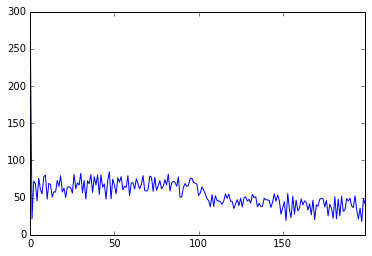

In [19]:
pd.Series(np.array(closingprices)*1000).plot()

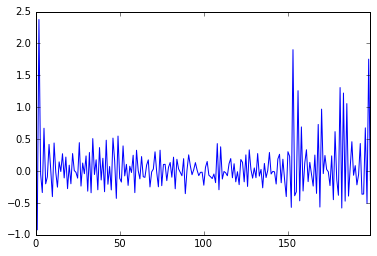

In [68]:
returns = pd.Series(np.array(closingprices)*1000).pct_change()
returns.plot()

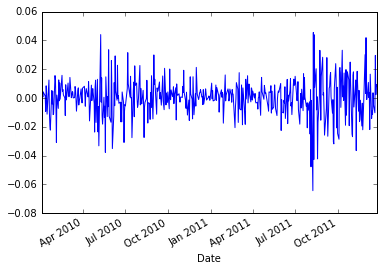

In [21]:
spy_returns[:500].plot()

In [22]:
# one measure for persistent volatility is plotting the autocorrelation of the absolute retunrs
absolute_returns = returns.abs()
autocorr_abs_returns = [absolute_returns.autocorr(lag=lag) for lag in range(25)]
absolute_spy_returns = spy_returns.abs()
autocorr_spy_abs_returns = [absolute_spy_returns.autocorr(lag=lag) for lag in range(25)]

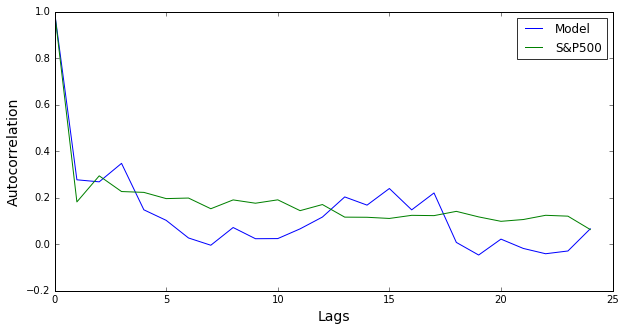

In [53]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(autocorr_abs_returns)), autocorr_abs_returns, label='Model')
ax1.plot(range(len(autocorr_spy_abs_returns)), autocorr_spy_abs_returns, label='S&P500')

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lags', fontsize='14')
fig.savefig('abs_returns_auto_correlation.png')

# Buy and sell orders

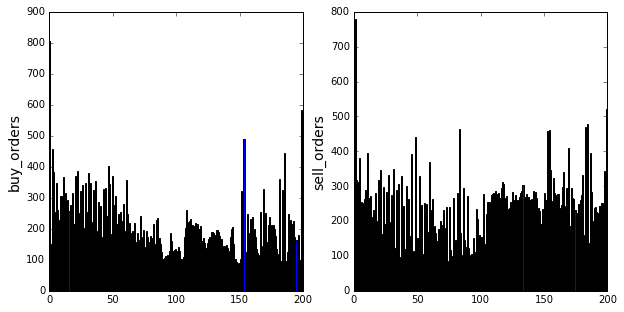

In [24]:
buy_orders = order_books[0].buy_orders_history
sell_orders = order_books[0].sell_orders_history
#sell_orders

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.bar(range(len(buy_orders)), buy_orders)
ax2.bar(range(len(sell_orders)), sell_orders)


ax1.set_ylabel('buy_orders', fontsize='14')
ax2.set_ylabel('sell_orders', fontsize='14')

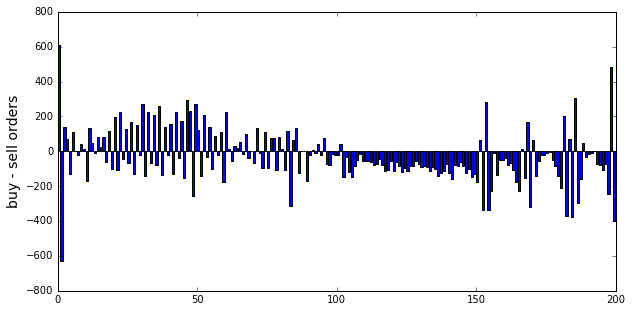

In [25]:
buy_minus_sell_orders = np.array(buy_orders) - np.array(sell_orders)

fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.bar(range(len(buy_minus_sell_orders)), buy_minus_sell_orders)


ax1.set_ylabel('buy - sell orders', fontsize='14')

# Market Prices and Volume

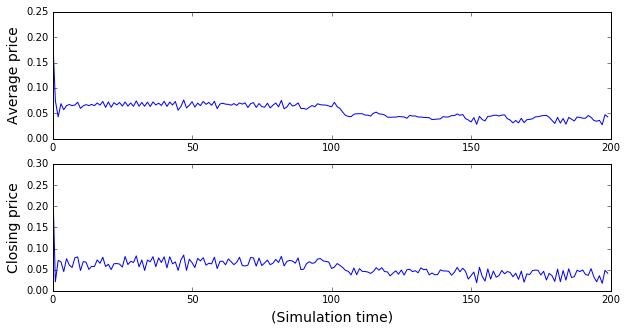

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5))

ax1.plot(range(len(averageprices)), averageprices)
ax2.plot(range(len(closingprices)), closingprices)

ax1.set_ylabel('Average price', fontsize='14')
ax2.set_ylabel('Closing price', fontsize='14')
ax2.set_xlabel('(Simulation time)', fontsize='14')

In [27]:
volume = order_books[0].transaction_volumes_history
totalvolume = []
for day in volume:
    totalvolume.append(sum(day))

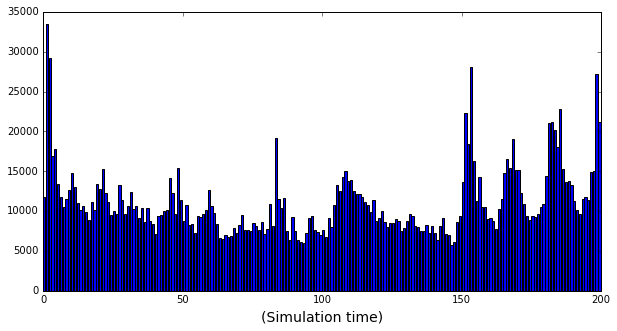

In [28]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.bar(range(len(totalvolume)), totalvolume)

ax1.set_xlabel('(Simulation time)', fontsize='14')

## Intraday prices

In [57]:
all_transaction_prices = order_books[0].transaction_prices_history

In [58]:
all_transaction_prices = list(itertools.chain.from_iterable(all_transaction_prices))

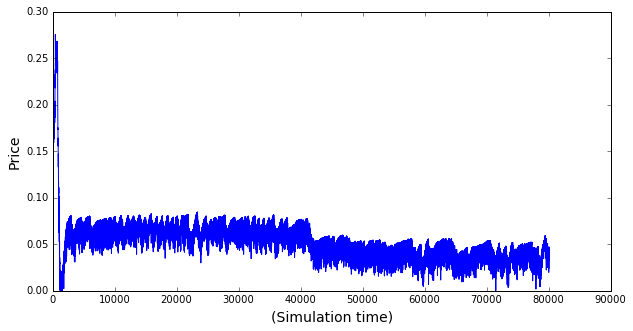

In [60]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

zoomed_prices = all_transaction_prices

ax1.plot(range(len(zoomed_prices)), zoomed_prices)

ax1.set_ylabel('Price', fontsize='14')
ax1.set_xlabel('(Simulation time)', fontsize='14')

# Strategy switching

In [54]:
def percentageMomentum(period, agents):
    momentum = 0
    queryString = 'momentum'
    for agent in agents:
        function = str(agent.function_history[period])
        if queryString in function:
            momentum += 1
    return momentum / (len(agents))

In [88]:
percMom = []
for period in range(SIMTIME):
    percMom.append(percentageMomentum(period, agents))

In [92]:
share_noise_traders = np.array([1 - calibratedParams['share_chartists'] for x in range(SIMTIME)])
share_momentum = np.array(percMom)
percMeanRev = np.ones(SIMTIME) - share_noise_traders - share_momentum

In [107]:
colors= plt.cm.Set1(np.linspace(0, 1, 12))

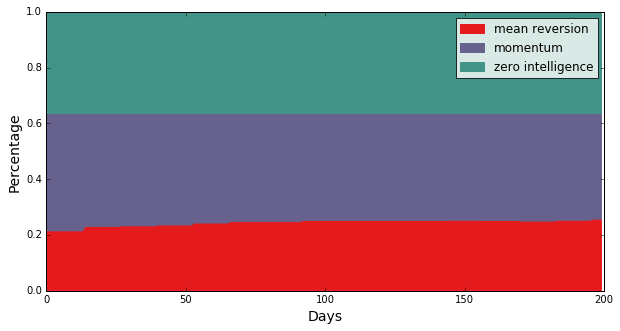

In [114]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

#ax1.plot(range(len(percFund)), share_noise_traders, label='noise')
#ax1.plot(range(len(percFund)), share_momentum, label='momentum')
ax1.fill_between(range(len(percFund)), percMeanRev, 0,label='mean reversion', alpha=1, color=colors[0])
ax1.fill_between(range(len(percFund)), share_momentum + percMeanRev, percMeanRev, label='momentum', color=colors[1], alpha=1)
ax1.fill_between(range(len(percFund)), 
                 share_noise_traders+share_momentum + percMeanRev, share_momentum + percMeanRev,label='zero intelligence', color=colors[2])
#ax1.set_ylim(0.1, 0.3)


ax1.set_ylabel('Percentage', fontsize='14')
ax1.set_xlabel('Days', fontsize='14')
ax1.legend(frameon=True, loc='best', framealpha=0.8)
fig.savefig('trader_population.png')

## Model dynamics

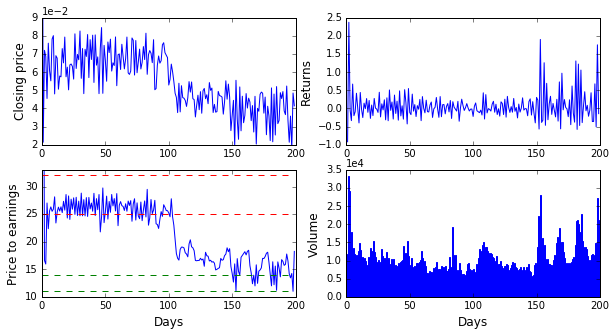

In [80]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,5))

ax1.plot(range(len(closingprices)), closingprices)
ax1.set_ylim(0.02, 0.09)
ax1.set_ylabel('Closing price', fontsize='12')

ax2.plot(range(len(returns)), returns)
ax2.set_ylabel('Returns', fontsize='12')

ax3.plot(range(len(price_to_earnings)), price_to_earnings)
ax3.plot(range(len(price_to_earnings)), [PE_low_low for x in range(len(price_to_earnings))], 'g--')
ax3.plot(range(len(price_to_earnings)), [PE_low_high for x in range(len(price_to_earnings))], 'g--')
ax3.plot(range(len(price_to_earnings)), [PE_high_low for x in range(len(price_to_earnings))], 'r--')
ax3.plot(range(len(price_to_earnings)), [PE_high_high for x in range(len(price_to_earnings))], 'r--')
ax3.set_ylim(10, 33)
ax3.set_ylabel('Price to earnings', fontsize='12')
ax3.set_xlabel('Days', fontsize='12')

ax4.bar(range(len(totalvolume)), totalvolume, edgecolor='b')
ax4.set_ylabel('Volume', fontsize='12')
ax4.set_xlabel('Days', fontsize='12')



for ax in [ax1, ax2, ax3, ax4]:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    
fig.savefig('model_dynamics.png')

# Stylized facts

Most of the text comes from: Rama Cont (2001) Journal of Quantitative Finance

How to replicate these? 
* centrifugal forces (for volatility clusering and fat tails) = mean reversion, trend following & fundamental component)
* very low autocorrelation? ... stochasticity? 
* large positive autocorrelation in volume? 

## 1 Returns

In [37]:
returns = pd.Series(averageprices).diff()
squared_returns = np.square(returns)

In [38]:
stats = [returns.std(), returns.min(), returns.max(), returns.skew(), returns.kurtosis()]
sp500 = [0.008, -0.082, 0.051, -0.187, 8.512]
index = ['standard_deviation', 'minimum', 'maximum', 'skewness', 'kurtosis']

In [39]:
pd.DataFrame({'Simulation':stats, 'S&P500': sp500}, index=index)

,S&P500,Simulation
standard_deviation,0.008,0.011726
minimum,-0.082,-0.132159
maximum,0.051,0.026057
skewness,-0.187,-7.152298
kurtosis,8.512,79.551861


### 1.1 Very low autocorrelation

(linear) autocorrelations of asset returns are often insignificant, except for very
small intraday time scales ( 20 minutes) for which microstructure effects come into play.

add a bit of stochasticity? 

In some models such as Ghonghadze & Lux 2016. Changes in the fundamental value are driven by a brownian motion, which in turn drives the low autocorrelations. 

In [47]:
autocorr_returns = [returns.autocorr(lag=lag) for lag in range(25)]
#autocorr_squared_returns = [squared_returns.autocorr(lag=lag) for lag in range(25)]
autocorr_spy_returns = [spy_returns[200:].autocorr(lag=lag) for lag in range(25)]

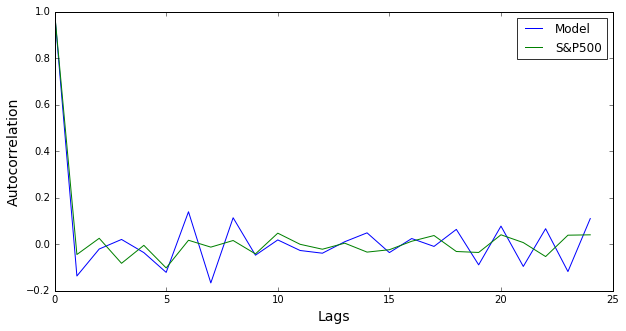

In [51]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(autocorr_returns)), autocorr_returns, label='Model')
#ax1.plot(range(len(autocorr_squared_returns)), autocorr_squared_returns)
ax1.plot(range(len(autocorr_spy_returns)), autocorr_spy_returns, label='S&P500')

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lags', fontsize='14')
fig.savefig('auto_correlation.png')

### 1.2 Fait tails

fat tails of the unconditional distribution
of returns

**How to measure: calculate the powerlaw exponent (alpha)**

In [37]:
h = sorted(list(returns[1:]))
hmean = np.mean(h)
hstd = np.std(h)
pdf = stats.norm.pdf(h, hmean, hstd)
plt.plot(h, pdf)
plt.hist(h, normed=True)

AttributeError: 'list' object has no attribute 'norm'

### Power law exponent / alpha

the tails of the distribution at the shortest time scales were reported to be well-approximated by a powerlaw with exponent α ≈ 3. This tail might be a consequence of powerlaw tails in both the distribution of market order sizes and the instantaneous mid-price logarithmic return impact function. in emerging markets. Dro˙zd˙z et al. (2007) reported that the tails were less heavy (i.e. α > 3).  Longer time scales should lead to a closer and closer approximation by the normal distribution

In [38]:
results = powerlaw.Fit(returns[1:])
print(results.power_law.alpha)

Calculating best minimal value for power law fit
C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\powerlaw.py:1138: RuntimeWarning: invalid value encountered in log
  self.alpha = 1 + (self.n / sum(log(data/self.xmin)))
C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\powerlaw.py:1157: RuntimeWarning: invalid value encountered in log
  return 1 + len(data)/sum(log(data / (self.xmin)))
C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\powerlaw.py:698: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


2.79419911075


C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


### 1.3 Clustered volatility

Volatility clustering characterizing their conditional distribution. Probably tied to over-optimism / over pessimism. 

### 1.3.1 Autocorrelation absolute returns 

In [40]:
# one measure for persistent volatility is plotting the autocorrelation of the absolute retunrs
absolute_returns = returns.abs()
autocorr_abs_returns = [absolute_returns.autocorr(lag=lag) for lag in range(25)]
absolute_spy_returns = spy_returns.abs()
autocorr_spy_abs_returns = [absolute_spy_returns.autocorr(lag=lag) for lag in range(25)]

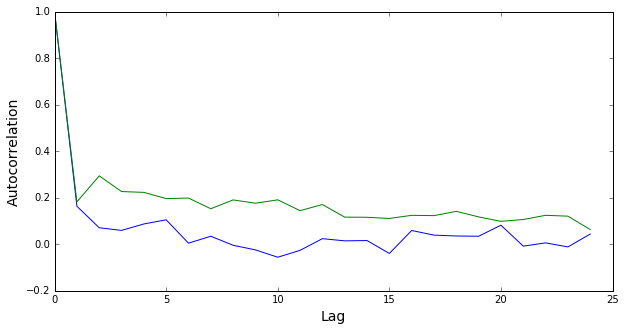

In [41]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(autocorr_abs_returns)), autocorr_abs_returns)
ax1.plot(range(len(autocorr_spy_abs_returns)), autocorr_spy_abs_returns)

ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')

## 2 Volume
### 2.1 Large positive autocorrelation

In [115]:
vol = pd.Series(totalvolume)

In [123]:
autocorr_volume = [vol.autocorr(lag=lag) for lag in range(25)]
autocorr_spy_volume = [spy_volume[200:].autocorr(lag=lag) for lag in range(25)]

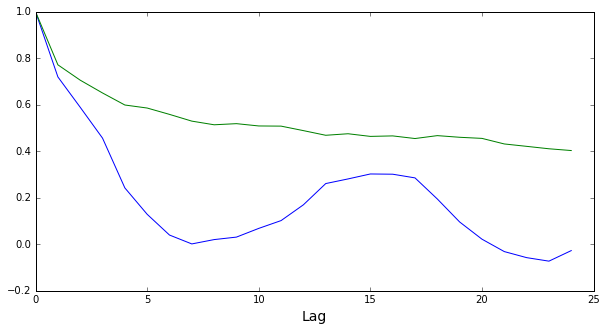

In [156]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(autocorr_volume)), autocorr_volume)
ax1.plot(range(len(autocorr_spy_volume)), autocorr_spy_volume)


#ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')

### 2.2 Correlation between high price volatility and large volumes

In [138]:
window = 10
roller_sim_vol = vol.rolling(window)
volatility_sim_vol = roller_sim_vol.std(ddof=0)
roller_spy_vol = spy_volume[:200].rolling(window)
volatility_spy_vol = roller_spy_vol.std(ddof=0)

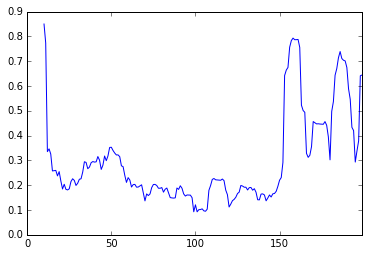

In [141]:
roller_returns = returns.rolling(window)
returns_volatility = roller_returns.std(ddof=0)
returns_volatility.plot()

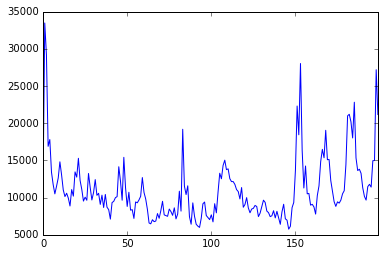

In [142]:
vol.plot()

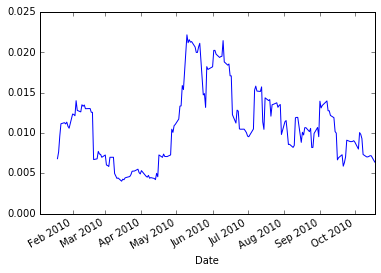

In [148]:
spy_roller_returns = spy_returns[:200].rolling(window)
spy_returns_volatility = spy_roller_returns.std(ddof=0)
spy_returns_volatility.plot()

# Correlation between price volatility and volume

In [149]:
spy_returns_volatility.corr(spy_volume[:200])

0.46710382324483518

In [143]:
returns_volatility.corr(vol)

0.46104934911913575